<div style="margin: 0 auto 30px; height: 60px; border: 2px solid gray; border-radius: 6px;">
  <div style="float: left;"><img src="img/epfl.png" /></div>
  <div style="float: right; margin: 20px 30px 0; font-size: 10pt; font-weight: bold;"><a href="https://moodle.epfl.ch/course/view.php?id=18253">COM202 - Signal Processing</a></div>
</div>
<div style="clear: both; font-size: 30pt; font-weight: bold; color: #483D8B;">
    Lab 7: Discrete-time Filters
</div>

In this notebook we will learn how to implement and use two discrete-time  filters called the Leaky Integrator and the Moving Average. In spite of their simplicity, these two lowpass filters are extremely useful and they often represent a good initial stand-in for more complex filters when prototyping a signal processing application.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import IPython
import scipy.signal as sp
from scipy.io import wavfile

# interactivity library:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
plt.rcParams["figure.figsize"] = (14,4)

# Implementing discrete-time filters

Although filtering algorithms are available in SciPy, it's always instructive to try and code a digital filter from scratch in order to understand the finer details of a practical implementation. 

## Filters as Python functions

Using Python and NumPy, filters can be implemented as standalone [pure functions](https://en.wikipedia.org/wiki/Pure_function); the arguments are going to be:
 * an array containing the entire input signal,
 * the filter description,
 
and the return value is an array containing the entire output signal, as shown in this template:

In [5]:
def dt_filter(x: np.ndarray, filter_parameters) -> np.ndarray:
    y = np.zeros(len(x))
    for n in range(0, len(x)):
        y[n] =filter_parameters(x[n])   # compute each output sample        
    return y

### Causality and zero initial conditions

Filters are considered causal by default, and therefore the computation of each output sample $y[n]$ involves only _past_ input and output samples.

The input array passed as an argument is interpreted as containing the values $x[0], x[1], \ldots, x[N-1]$. The input is also assumed to be a causal sequence, so that $x[n] = 0$ for $n <  0$; if the algorithm requires accessing past values of $x[n]$ for negative values of the index $x$, these values are assumed to be zero.

Similarly, we assume _zero initial conditions_ for recursive filters that use past _output_ values in the computation of the current output sample. Zero initial conditions imply that $y[n] = 0$ for $n < 0$.

### Termination

The input to the filtering function is an array of length $N$ and, by convention, the return value is also an array of length $N$. Note however that this does not mean that $y[n] = 0$ for $n \ge N$, it simply means that no more output samples can be computed unless more input samples are provided.

In fact, if for instance we were to assume that $x[n]=0$ for $n \ge N$, an IIR filter would produce an infinite-length output sequence $y[n]$. Sometimes, it is useful to append a suitable amount of zeros to the input array so that the output can naturally decay to a small amplitude once the actual data in the array has been processed.

## The Leaky Integrator

The following function implements a Leaky Integrator described by the constant-coefficient difference equation (CCDE) 

$$
    y[n] = \lambda y[n-1] + (1-\lambda)x[n], \qquad 0 < \lambda < 1.
$$

In [6]:
def leaky(x: np.ndarray, lam: float) -> np.ndarray:
    y = np.zeros(len(x))
    for n in range(0, len(x)):
        y[n] = lam * y[n-1] + (1 - lam) * x[n]        
    return y

### Ensuring zero initial conditions 

The Leaky Integrator is a recursive (IIR) filter and its output at time $n$ depends on the output at time $n-1$; assuming zero initial conditions, when $n=0$ the required "previous output value" is $y[-1] = 0$. 

In the implementation above, when `n > 0` the expression `y[n-1]` is indeed pointing to the previously-computed output value. In the first iteration, however, `n` is equal to zero and so the expression `y[n-1]` is equivalent to `y[-1]`. Contrary to many other programming languages Python allows negative indexing so that  `y[-1]` actually points to the _last_ element in the array `y`. Since the output array `y` is pre-allocated and filled with zeros, `y[-1]` is indeed equal to zero as required.

### Testing the code

The impulse response of the Leaky Integrator is $h[n] = (1-\lambda)\lambda^n u[n]$ and we can verify that the above implementation is correct by comparing the theoretical values to the output of the function when the input is a (truncated) delta sequence:

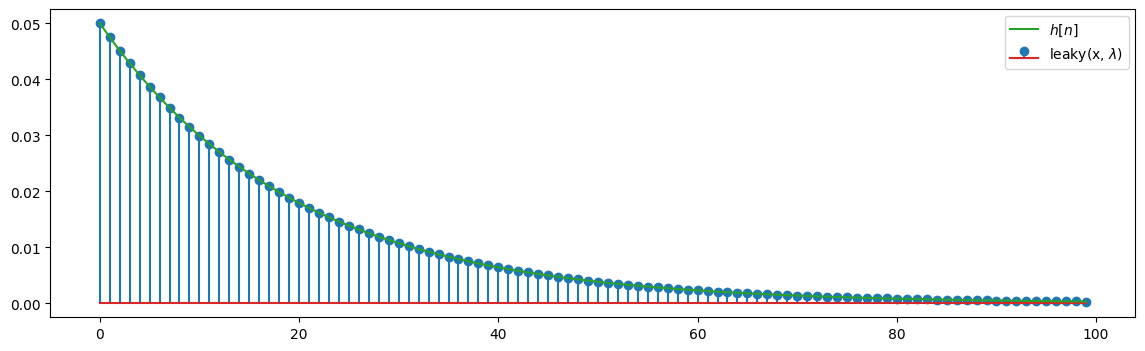

In [7]:
N = 100
lam = 0.95
plt.stem(leaky(np.r_[1, np.zeros(N-1)], lam), label=r"leaky(x, $\lambda$)");
plt.plot((1 - lam) * lam ** np.arange(0, N), 'C2', label=r"$h[n]$");
plt.legend();

## The Moving Average

The causal Moving Average filter of length $M$ is described by the CCDE

$$
    y[n] = \frac{1}{M}\sum_{k=0}^{M-1}x[n-k].
$$

The Moving Average is an FIR filter, that is, each output sample is computed using only past input samples; in a practical implementation, values for $x[n]$ when $n<0$ are equal to zero because of the causality assumption for $x[n]$.

### Exercise: implement the Moving Average filter

Complete the code below

In [89]:
def mavg(x: np.ndarray, M: int) -> np.ndarray:
    y = np.zeros(len(x))
    for n in range(0, len(x)):
        y[n] = sum(x[n-k] if n-k >= 0 else 0 for k in range(0,M)) / M
    return y

Let's test your implementation:

In [91]:
y = mavg((-1) ** np.arange(0, 40), 20)  # test signal, filtered
print(y)
print('good job!' if np.sum(y[1::2]) == 0 and np.sum(y[:20:2]) == 0.5 else 'Sorry, try again!')

[0.05 0.   0.05 0.   0.05 0.   0.05 0.   0.05 0.   0.05 0.   0.05 0.
 0.05 0.   0.05 0.   0.05 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
good job!


# Applications


## Denoising

In a denoising scenario we have a "clean" signal $x[n]$ that has been corrupted by an additive noise signal $\eta[n]$; we only have access to $\hat{x}[n] = x[n] + \eta[n]$ and we would like to recover $x[n]$.

In general, without further assumptions, this is not a solvable problem. However, it is generally the case that the signal and the noise have very different characteristics and, in this case, we can try to reduce the amount of noise via filtering. Typically, if we look in the time domain:
 * the clean signal is varying slowly and smoothly
 * the noise is low-amplitude with respect to the signal and it varies very fast from one sample to the next.
 
These two characteristics translate to the following properties in the frequency domain:
 * the clean signal contains most of its energy in the low frequencies around zero
 * the noise has a full-band spectrum, with almost equal energy at all frequencies.

### A signal generator

The following function can be used to generate an $N$-point smooth signal together with a noise-corrupted version at the specified signal to noise ratio; the spectrum of the smooth signal will contain most of its energy in the $[-B\pi, B\pi]$ range. You don't need to worry about how the function works, simply use it as a black box.

In [93]:
def sig_gen(N: int, SNR: float, B=0.04, x=None) -> [np.ndarray, np.ndarray]:
    if x is None:
        X = np.r_[0, np.random.uniform(-1, 1, 2 * int(N * B) + 1)]
        x = np.real(np.fft.ifft(X, 2*N))[:N] / np.sqrt(2 * B / 3 / N)
    a = np.sqrt((3.0 / 8.0) / np.power(10, SNR / 10)) 
    return x, x + np.random.uniform(-a, a, len(x))

Use the following interactive widget to play with the SNR and the B parameters and try to get a feel for their effect on the  signal generated by the function:

In [94]:
def display(SNR=15, B=0.02):
    x, x_hat = sig_gen(1000, SNR, B, display.prev[1] if B == display.prev[0] else None)
    display.prev = [B, x]
    plt.plot(x, 'C0', lw=2, label='clean');
    plt.plot(x_hat, 'C3', lw=1, label='noisy');
    plt.ylim(-1.2,1.2);
    plt.legend(loc="upper right");

display.prev = [0, None]
    
interact(display, SNR=(0.0, 50.0), B=(0.01, 0.09, 0.01));

interactive(children=(FloatSlider(value=15.0, description='SNR', max=50.0), FloatSlider(value=0.02, descriptio…

### Exercise: checking the SNR

Given a noise-corrupted signal $\hat{x}[n] = x[n] + \eta[n]$, the signal-to-noise ratio is expressed in dB and is computed as 

$$
    \text{SNR}_{\hat{x}} = 10 \log_{10}\left(\frac{E_x}{E_\eta}\right)
$$

where $E_x$ is the energy of the clean signal and $E_\eta$ is the energy of the noise. 

Generate a noisy signal and verify numerically that the SNR of the sequence returned by `sig_gen()` is indeed close to the SNR passed as an argument to the function.

In [95]:
N, SNR = 1000, 30
x, x_hat = sig_gen(N, SNR)
E_x = np.sum(np.abs(x) ** 2) / N
E_eta = np.sum(np.abs(x_hat - x) ** 2) / N
SNR_exp = 10 * np.log10(E_x / E_eta)

### Denoising: time-domain experiments

The following interactive widget allows you to play with the SNR of the noisy signal and with the parameter $\lambda$ of a leaky integrator to see the denoising performance of the filter in the time domain. Try to find a value for $\lambda$ that provides a good compromise between removal of the noise and preservation of the original clean signal.

In [96]:
def display(SNR=12, lam=0.5):
    if SNR != display.state[0]:
        display.state = [SNR, *sig_gen(500, SNR, x=display.state[1])]
    x, x_hat = display.state[1], display.state[2] 
    plt.plot(x_hat, 'C3', lw=1, label='noisy');
    plt.plot(x, 'C0', lw=2, label='clean');
    plt.plot(leaky(x_hat, lam), 'C2', lw=2, label='denoised');
    plt.ylim(-1.2,1.2)
    plt.legend(loc="upper right");
display.state = [0, None]
    
interact(display, SNR=(0.0, 50.0), lam=(0.49,0.99,0.02));

interactive(children=(FloatSlider(value=12.0, description='SNR', max=50.0), FloatSlider(value=0.5, description…

### Exercise: denoising in frequency

Plot the magnitude spectra of the clean, noisy, and denoised signals, together with the magnitude response of the leaky integrator using the values for SNR and for $\lambda$ that you chose before using the widget. 

Remember that the magnitude response of the Leaky Integrator is 

$$
    |H(e^{j\omega})| = \frac{(1-\lambda)}{\sqrt{1 - 2\lambda \cos\omega + \lambda^2}}.
$$

To obtain the plot:
 * plot the filter's magnitude response over the $[-\pi, \pi]$ interval using the analytic expression above
 * compute $E_x$, the energy of the clean signal, then normalize the clean, noisy and denoised signals by $E_x$ before computing their DFTs
 * plot the magnitude of the DFTs so that they are aligned with the frequency response of the filter (exactly in the same way as in Question 7 in Homework set 5)

In [ ]:
# your code here



### Exercise: denoising with the Moving Average filter

Modify the time-domain denoising widget and the code you wrote for the previous exercise so that they use a Moving Average filter instead of a Leaky Integrator. Which filter works best in your opinion?

## Detrending

In many (if not all) signal processing applications, we prefer signals to be _balanced,_ that is, we want the average value of the signal to be zero. Indeed, all physical processing devices (and digital devices in particular) can only deal with a finite range of possible input values before things like distortion or breakdown start to happen, and this nominal input range is usually centered around zero. If a signal is not balanced, it will not be able to fully use the available input range of a processing device.

As an example, assume that a processing device can only accept input values in the interval $[-1, 1]$; a signal $x[n]$ such that $\max_n\{x[n]\} = 0.8$ and $\min_n\{x[n]\} = -0.8$ will be processed without problems; but the unbalanced signal $y[n] = x[n] + 0.5$ will exceed the device's input limits even though the signal's range, $\max_n\{y[n]\} - \min_n\{y[n]\}$, is the same as for $x[n]$.

In these cases, a Leaky Integrator or a Moving Average filter can be used to _detrend_ a signal, that is, remove its estimated mean value to obtain a balanced signal.

As you may have noticed while playing with the interactive widget before, if you push the value of $\lambda$ very close to one in a Leaky integrator, the output of the filter tends to converge to the mean.

### Exercise: average estimation with Leaky Integrator and Moving Average

The following cell creates a signal and offsets it by a constant amount. Use a Leaky Integrator and a Moving Average filter to estimate the value of the offset in order to balance back the signal. Plot the value of the estimated mean and find the values for $\lambda$ and $M$ that provide a comparable performance.

In [ ]:
offset = 0.5
x, _ = sig_gen(2000, 100)
x_off = x + offset

In [ ]:
avg_li = ...
avg_ma = ...


## VU meters

<div style="float: right; margin: 10px;"><img src="img/vumeter.gif" width="180"></div>

An analog [VU-meter](https://en.wikipedia.org/wiki/VU_meter), as the one shown on the right, is a device used in audio recording equipment to visually monitor the _short-term power_ of a signal, namely the power of the signal computed over a short time window spanning a few milliseconds of past data. 

For a discrete-time signal, the short-term power at time $n$ can be computed as 
$$
    p_M[n] = \frac{1}{M}\sum_{k = 0}^{M-1}|x[n-k]|^2
$$
which is clearly the result of filtering the _squared_ input signal with an $M$-point Moving Average.

### Exercise: short-term power estimation

If you remember our [previous lab on DTMF signals](https://github.com/LCAV/COM202/tree/main/05-DTMF) one of the most important steps in the decoding process was the _segmentation_ of the input signal to isolate the different digit tones. This was accomplished by computing the local power of the signal and by comparing it to a threshold to separate the silent gaps. Let's load a DTMF signal and play it:

In [ ]:
fs, dtmf = wavfile.read('data/dtmf.wav')
IPython.display.Audio(dtmf, rate=fs)

Complete the function below so that it returns an estimate of the local power of the input signal over a window spanning the given number of milliseconds. 

In [ ]:
def vu_meter(x: np.ndarray, fs: int, span_ms: float) -> np.ndarray:
    ...

Let's see the results:

In [ ]:
plt.plot(dtmf, label="DTMF");
plt.plot(vu_meter(dtmf, fs, 20), label="VU Meter output");
plt.legend();

# A last trick for the road

Let's finish with a fun and surprising trick. Let's load an audio file and play it; you shouldn't hear anything:

In [ ]:
fs, s = wavfile.read('data/testing.wav')
IPython.display.Audio(s, rate=fs)

What if we filter the signal before playing? 

In [ ]:
M = 36
IPython.display.Audio(mavg(s, M), rate=fs)

Still nothing. But check this out:

In [ ]:
IPython.display.Audio(mavg(s ** 2, M), rate=fs)

Cool, isn't it? Can you figure out what happened and why squaring the signal made the audio magically appear? 

If you feel like investigating, start by looking at plots of the signal both in the time and in the frequency domain, and then try to understand how the original signal was generated. If after a while you're still clueless, you may want to use this [hint](https://en.wikipedia.org/wiki/Crystal_detector). 